# Evaluate success of events

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import io
from PIL import Image

from Functions import *

## Case studies

22nd February 2015 - 'White Night' - actually from 7pm on the 21st until 7am on the 22nd  
16th July 2021 - lockdown announced

### Read in Melbourne sensor location spatial data

In [2]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

### Define parameters

In [3]:
buffer_size_m = 400
input_csv="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)
sensor_ids = pd.read_csv(input_csv)['sensor_id']

### Read in predictions from running model with CV (in other script)

In [4]:
predictions = pd.read_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m))["0"]
len(predictions)

4129082

### Reformat predictions as a dataframe

In [5]:
# Get all relevant data in one dataframe
predictions_df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'] ,'sensor_id':sensor_ids, 'AbsolouteError':abs(Yfull-predictions),
                 'Error':Yfull-predictions, 'datetime':data_time_columns['datetime']})
# Add hour of week variable
predictions_df['hour_of_week'] = predictions_df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
predictions_df=predictions_df.sort_values(by=['Weekday', 'Hour'])
# Add percentage increase column
predictions_df['Percentage_Increase']= ((predictions_df['Real_vals'] - predictions_df['Predictions']) / abs(predictions_df['Predictions'])) * 100
# Convert date time column to correct format
predictions_df["datetime"]  = pd.to_datetime(predictions_df["datetime"] , errors='coerce')

### Find hours with biggest error

In [323]:
# predictions_df.nlargest(10, 'Error')

### Dates
New year = '2019-01-01' (fireworks at Docklands)  
Initial covid lockdown = '2020-03-31'  
Another covid lockdown = '2021-07-16'  
White night =  '2015-01-22'  
Anzac day = '2015-04-25'  
Moomba Day = '2020-03-07'

22.3%


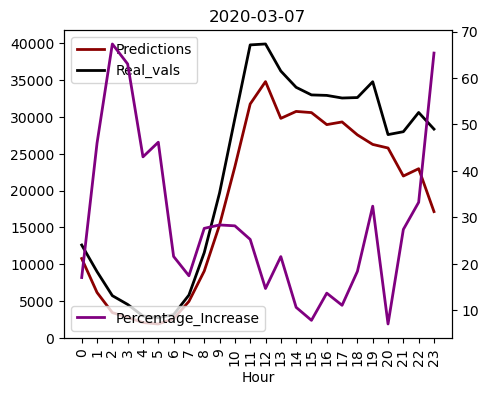

In [534]:
# # Define the special date
special_date =  '2020-03-07' # '2015-04-25'

# # Get data just from this date
special_dates_data = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

# # Option for whole of Australian open month 
# special_dates_data = predictions_df.loc[(predictions_df['datetime'] > '2021-02-08') & (predictions_df['datetime']<= '2021-02-26')]

# # find overall error this day
# # print(str(round(special_dates_data['Real_vals'].sum()/special_dates_data['Predictions'].sum() * 100,1)) + '%')
print(str(round((special_dates_data['Real_vals'].sum() - special_dates_data['Predictions'].sum()) / abs(special_dates_data['Predictions'].sum()) * 100,1)) + '%')

# Get plot of error throughout day (across all sensors)
find_hourly_errors_on_date(special_dates_data, special_date)   
# Get plot of error across city (across all hours)
find_sensorly_errors_on_date(special_dates_data, special_date, melbourne_sensors)    

### Focus on hours with biggest change

In [517]:
hours_affected = special_dates_data[special_dates_data['Hour'].between(0,3)]
hours_not_affected = special_dates_data[special_dates_data['Hour'].between(4,23)]
# print(str(round(hours_affected['Real_vals'].sum()/hours_affected['Predictions'].sum() * 100,1)) + '%') 
# print(str(round(hours_not_affected['Real_vals'].sum()/hours_not_affected['Predictions'].sum() * 100,1)) + '%') 
print(str(round((hours_affected['Real_vals'].sum() - hours_affected['Predictions'].sum()) / abs(hours_affected['Predictions'].sum()) * 100,0)) + '%') 
print(str(round((hours_not_affected['Real_vals'].sum() - hours_not_affected['Predictions'].sum()) / abs(hours_not_affected['Predictions'].sum()) * 100,0)) + '%')

-57.0%
-63.0%


### Look at just data for sensor with biggest difference
Sensor 29 for Anzac Day  
Sensors 11 and 12 for NY 2019

### Find sensor with biggest difference

In [529]:
special_date_sensorly_values =special_dates_data.groupby(['sensor_id']).sum()
special_date_sensorly_values.drop(['Weekday', 'Percentage_Increase', 'AbsolouteError', 'Error', 'Hour'], axis=1, inplace=True)

### Add error metrics
special_date_sensorly_values['AbsolouteError'] = abs(special_date_sensorly_values['Real_vals']-special_date_sensorly_values['Predictions'])
special_date_sensorly_values['Error'] = special_date_sensorly_values['Real_vals']-special_date_sensorly_values['Predictions']
special_date_sensorly_values['Percentage_Increase'] = ((special_date_sensorly_values['Real_vals'] - special_date_sensorly_values['Predictions']) / abs(special_date_sensorly_values['Predictions'])) * 100

sensor_id = special_date_sensorly_values.nlargest(1, 'Percentage_Increase').index[0]


### Look at pre hour breakdown for this sensor

In [533]:
test = special_dates_data[special_dates_data['sensor_id'] == sensor_id ] #11
test.index = test['Hour']
def fill_missing_range(df, field, range_from, range_to, range_step=1, fill_with=0):
    return df\
      .merge(how='right', on=field,
            right = pd.DataFrame({field:np.arange(range_from, range_to, range_step)}))\
      .sort_values(by=field).reset_index().fillna(fill_with).drop(['index'], axis=1)

test.reset_index(inplace=True, drop=True)
test = fill_missing_range(test, 'Hour', 0, 24, 1, np.nan)

# find overall error this day
print(str(round(test['Real_vals'].sum()/test['Predictions'].sum() * 100,1)) + '%')
test

336.6%


,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Increase
0,25.79,41.0,0,6.0,7.0,15.21,15.21,2020-03-07 00:00:00,w6_h0,58.976347
1,38.92,47.0,1,6.0,7.0,8.08,8.08,2020-03-07 01:00:00,w6_h1,20.760534
2,9.59,26.0,2,6.0,7.0,16.41,16.41,2020-03-07 02:00:00,w6_h2,171.115746
3,12.16,15.0,3,6.0,7.0,2.84,2.84,2020-03-07 03:00:00,w6_h3,23.355263
4,11.53,24.0,4,6.0,7.0,12.47,12.47,2020-03-07 04:00:00,w6_h4,108.152645
5,11.31,42.0,5,6.0,7.0,30.69,30.69,2020-03-07 05:00:00,w6_h5,271.352785
6,25.27,42.0,6,6.0,7.0,16.73,16.73,2020-03-07 06:00:00,w6_h6,66.204986
7,70.05,103.0,7,6.0,7.0,32.95,32.95,2020-03-07 07:00:00,w6_h7,47.037830
8,212.56,136.0,8,6.0,7.0,76.56,-76.56,2020-03-07 08:00:00,w6_h8,-36.018065
9,151.67,290.0,9,6.0,7.0,138.33,138.33,2020-03-07 09:00:00,w6_h9,91.204589


### Plot the hourly trend for this one sensor

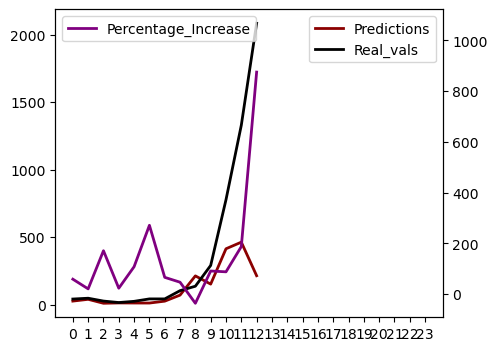

In [531]:
fig, ax = plt.subplots(figsize = (5,4), sharex = True)
ax2 = ax.twinx()
fig = test['Predictions'].plot(ax=ax, color='darkred', linewidth=2, legend =True)
fig = test['Real_vals'].plot(ax=ax, color='black', linewidth=2, legend =True)
fig = test['Percentage_Increase'].plot(ax=ax2, color='purple', linewidth=2, legend =True)
ax.set_xticks(range(0,len(test.index)))
ax.set_xticklabels(test.index);

## Error per sensor at midnight

In [521]:
# midnight = special_dates_data[special_dates_data['datetime'] ==pd.to_datetime('01/01/2019 00:00:00')]
# find_sensorly_errors_on_date(midnight, special_date, melbourne_sensors)    